In [39]:
%matplotlib inline


# 03 Gradient Boosting regression


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
from datetime import datetime
import os
from tqdm import tqdm

pd.set_option('display.max_columns', 30)
pd.set_option('display.precision', 3)


## Time-independent regression with `df_X_pca` and `df_y`




In [2]:
df_X_pca = pd.read_pickle('df_X_pca.pkl')
X_cols = df_X_pca.columns

df_y = pd.read_pickle('df_y.pkl')
y_cols = df_y.columns

X = df_X_pca.to_numpy()
y = df_y.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1229, 50) , y.shape =  (1229, 6)


### Train-val-test split

Even when attempting time-independent regression, we cannot shuffle the data set before making train and test plit. If the model should be able to predict output variables ahead in time, it has to work well on a chronologically split data set.

For validation during training, the Gradient Boosting class of sklearn.ensemble defines a validation set automatically based on the `validation_fraction` parameter.


In [3]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

Note = 'PCA50. Random train/val but end as test.'

X_train: (983, 50) X_test: (245, 50)
y_train: (983, 6) y_test: (245, 6)


In [4]:
params = {
    "n_estimators": 300,
    "max_depth": 3,
    'max_features': 40,
    'subsample': 0.8,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "huber", #loss{‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}, default=’squared_error’
    "criterion": "squared_error", #criterion{‘friedman_mse’, ‘squared_error’}, default=’friedman_mse’
    'validation_fraction': 0.25,
    'n_iter_no_change': 20,
}

### Fit regression model


In [6]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '03_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)

for i in tqdm(range(20)):

    start_time = datetime.now()

    # ----------------- Calculate root mean squared error of predictions and -------------------------
    # ----------------- store results in dataframe together with parameter values used -------------------------
    res_labels = ['Note']
    res_values = [Note]

    regs = []
    y_test_estimated = []
    y_test_error = []
    S_e_values = []

    for i in range(y_train.shape[1]):
        reg = GradientBoostingRegressor(**params, verbose=0) 
        history = reg.fit(X_train, y_train[:,i]) # Fit model for label i
        regs.append(reg)

        y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
        y_test_error.append(y_test[:,i] - y_test_estimated[i])
        S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
        res_values.append(S_e)
        label = y_cols[i]
        res_labels.append(label+' S_e')

        S_e_values.append(S_e)

    res_labels.append('S_e mean')
    res_values.append(np.mean(S_e_values))

    for key in params.keys():
        res_values.append(params[key])
        res_labels.append(key)

    training_time = (datetime.now() - start_time).total_seconds()
    res_values.append(training_time)
    res_labels.append('Training time')

    df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
    fit_results = pd.concat([fit_results, df_tmp])
    #fit_results = fit_results.sort_values('R2', ascending=False)

fit_results.to_pickle(fit_file)
fit_results

100%|██████████| 20/20 [04:16<00:00, 12.82s/it]


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,n_estimators,max_depth,max_features,subsample,min_samples_split,learning_rate,loss,criterion,validation_fraction,n_iter_no_change,Training time
2023-05-02,PCA50. Random train/val but end as test.,1.180,0.732,1.103,0.754,0.896,1.109,0.962,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,13.286
2023-05-02,PCA50. Random train/val but end as test.,1.319,0.693,1.077,0.734,0.902,1.133,0.977,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,13.155
2023-05-02,PCA50. Random train/val but end as test.,1.235,0.689,1.026,0.714,0.866,1.057,0.931,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,16.060
2023-05-02,PCA50. Random train/val but end as test.,1.207,0.711,1.043,0.742,0.859,1.050,0.935,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,20.440
2023-05-02,PCA50. Random train/val but end as test.,1.271,0.678,1.021,0.768,0.861,1.057,0.943,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,11.972
2023-05-02,PCA50. Random train/val but end as test.,1.396,0.711,1.074,0.764,0.871,1.088,0.984,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,12.317
2023-05-02,PCA50. Random train/val but end as test.,1.263,0.723,1.042,0.717,0.873,1.059,0.946,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,11.591
2023-05-02,PCA50. Random train/val but end as test.,1.195,0.719,1.024,0.714,0.903,1.106,0.944,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,15.430
2023-05-02,PCA50. Random train/val but end as test.,1.328,0.706,1.114,0.721,0.804,1.121,0.966,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,12.487
2023-05-02,PCA50. Random train/val but end as test.,1.232,0.676,1.066,0.747,0.884,1.048,0.942,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,12.825


In [7]:
stats = fit_results.loc[fit_results['Note']=='PCA50. Random train/val but end as test.']
stats.loc['mean'] = stats.mean()
stats.loc['std'] = stats.std()
stats

C:\Users\christiano\AppData\Local\Temp\ipykernel_32804\393142404.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats.loc['mean'] = stats.mean()
C:\Users\christiano\AppData\Local\Temp\ipykernel_32804\393142404.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats.loc['std'] = stats.std()


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,n_estimators,max_depth,max_features,subsample,min_samples_split,learning_rate,loss,criterion,validation_fraction,n_iter_no_change,Training time
2023-05-02,PCA50. Random train/val but end as test.,1.180,0.732,1.103,0.754,0.896,1.109,0.962,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,13.286
2023-05-02,PCA50. Random train/val but end as test.,1.319,0.693,1.077,0.734,0.902,1.133,0.977,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,13.155
2023-05-02,PCA50. Random train/val but end as test.,1.235,0.689,1.026,0.714,0.866,1.057,0.931,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,16.060
2023-05-02,PCA50. Random train/val but end as test.,1.207,0.711,1.043,0.742,0.859,1.050,0.935,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,20.440
2023-05-02,PCA50. Random train/val but end as test.,1.271,0.678,1.021,0.768,0.861,1.057,0.943,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,11.972
2023-05-02,PCA50. Random train/val but end as test.,1.396,0.711,1.074,0.764,0.871,1.088,0.984,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,12.317
2023-05-02,PCA50. Random train/val but end as test.,1.263,0.723,1.042,0.717,0.873,1.059,0.946,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,11.591
2023-05-02,PCA50. Random train/val but end as test.,1.195,0.719,1.024,0.714,0.903,1.106,0.944,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,15.430
2023-05-02,PCA50. Random train/val but end as test.,1.328,0.706,1.114,0.721,0.804,1.121,0.966,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,12.487
2023-05-02,PCA50. Random train/val but end as test.,1.232,0.676,1.066,0.747,0.884,1.048,0.942,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,12.825


## Time dependent regression with `df_X_lagged` and `df_y_lagged`

The reason for not using `df_y` here is that `df_X_lagged` contains fewer rows and we need a coherent set of labels



In [8]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_pca.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1224, 330) , y.shape =  (1224, 6)


### Train-val-test split


In [9]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

Note = 'df_X_lagged. Random train/val but end as test.'

X_train: (979, 330) X_test: (244, 330)
y_train: (979, 6) y_test: (244, 6)


### Fit regression model


In [10]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '03_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)

for i in tqdm(range(20)):
    start_time = datetime.now()

    # ----------------- Calculate root mean squared error of predictions and -------------------------
    # ----------------- store results in dataframe together with parameter values used -------------------------
    res_labels = ['Note']
    res_values = [Note]

    regs = []
    y_test_estimated = []
    y_test_error = []
    S_e_values = []

    for i in range(y_train.shape[1]):
        reg = GradientBoostingRegressor(**params, verbose=0) 
        history = reg.fit(X_train, y_train[:,i]) # Fit model for label i
        regs.append(reg)

        y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
        y_test_error.append(y_test[:,i] - y_test_estimated[i])
        S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
        res_values.append(S_e)
        label = y_cols[i]
        res_labels.append(label+' S_e')

        S_e_values.append(S_e)

    res_labels.append('S_e mean')
    res_values.append(np.mean(S_e_values))

    for key in params.keys():
        res_values.append(params[key])
        res_labels.append(key)

    training_time = (datetime.now() - start_time).total_seconds()
    res_values.append(training_time)
    res_labels.append('Training time')

    df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
    fit_results = pd.concat([fit_results, df_tmp])
    #fit_results = fit_results.sort_values('R2', ascending=False)
    
fit_results.to_pickle(fit_file)
fit_results

100%|██████████| 20/20 [04:04<00:00, 12.21s/it]


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,n_estimators,max_depth,max_features,subsample,min_samples_split,learning_rate,loss,criterion,validation_fraction,n_iter_no_change,Training time
2023-05-02,PCA50. Random train/val but end as test.,1.180,0.732,1.103,0.754,0.896,1.109,0.962,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,13.286
2023-05-02,PCA50. Random train/val but end as test.,1.319,0.693,1.077,0.734,0.902,1.133,0.977,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,13.155
2023-05-02,PCA50. Random train/val but end as test.,1.235,0.689,1.026,0.714,0.866,1.057,0.931,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,16.060
2023-05-02,PCA50. Random train/val but end as test.,1.207,0.711,1.043,0.742,0.859,1.050,0.935,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,20.440
2023-05-02,PCA50. Random train/val but end as test.,1.271,0.678,1.021,0.768,0.861,1.057,0.943,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,11.972
2023-05-02,PCA50. Random train/val but end as test.,1.396,0.711,1.074,0.764,0.871,1.088,0.984,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,12.317
2023-05-02,PCA50. Random train/val but end as test.,1.263,0.723,1.042,0.717,0.873,1.059,0.946,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,11.591
2023-05-02,PCA50. Random train/val but end as test.,1.195,0.719,1.024,0.714,0.903,1.106,0.944,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,15.430
2023-05-02,PCA50. Random train/val but end as test.,1.328,0.706,1.114,0.721,0.804,1.121,0.966,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,12.487
2023-05-02,PCA50. Random train/val but end as test.,1.232,0.676,1.066,0.747,0.884,1.048,0.942,300,3,40,0.8,5,0.1,huber,squared_error,0.25,20,12.825


In [11]:
stats2 = fit_results.loc[fit_results['Note']=='df_X_lagged. Random train/val but end as test.']
stats2.loc['mean'] = stats2.mean()
stats2.loc['std'] = stats2.std()
stats2

C:\Users\christiano\AppData\Local\Temp\ipykernel_32804\2305634582.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats2.loc['mean'] = stats2.mean()
C:\Users\christiano\AppData\Local\Temp\ipykernel_32804\2305634582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats2.loc['mean'] = stats2.mean()
C:\Users\christiano\AppData\Local\Temp\ipykernel_32804\2305634582.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats2.loc['std'] = stats2.std()
C:\Users\christi

,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,n_estimators,max_depth,max_features,subsample,min_samples_split,learning_rate,loss,criterion,validation_fraction,n_iter_no_change,Training time
2023-05-02,df_X_lagged. Random train/val but end as test.,1.033,0.772,0.905,0.756,0.737,0.895,0.850,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,11.532
2023-05-02,df_X_lagged. Random train/val but end as test.,1.046,0.741,0.862,0.759,0.751,0.972,0.855,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,11.539
2023-05-02,df_X_lagged. Random train/val but end as test.,1.023,0.718,0.932,0.729,0.734,0.949,0.848,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,11.046
2023-05-02,df_X_lagged. Random train/val but end as test.,1.007,0.717,0.952,0.716,0.768,0.877,0.839,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,11.773
2023-05-02,df_X_lagged. Random train/val but end as test.,1.031,0.710,0.922,0.738,0.776,0.858,0.839,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,12.419
2023-05-02,df_X_lagged. Random train/val but end as test.,1.015,0.767,0.901,0.704,0.783,0.873,0.840,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,13.182
2023-05-02,df_X_lagged. Random train/val but end as test.,0.997,0.708,0.903,0.750,0.794,0.808,0.827,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,12.265
2023-05-02,df_X_lagged. Random train/val but end as test.,1.040,0.705,0.913,0.735,0.815,0.820,0.838,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,13.487
2023-05-02,df_X_lagged. Random train/val but end as test.,1.006,0.730,0.891,0.699,0.776,0.904,0.834,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,11.735
2023-05-02,df_X_lagged. Random train/val but end as test.,1.010,0.730,0.867,0.760,0.752,0.855,0.829,300,3,40,8.000e-01,5,1.000e-01,huber,squared_error,0.25,20,12.405


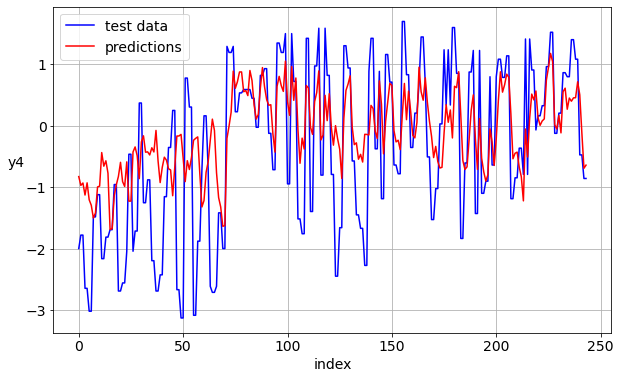

In [20]:
plt.rcParams["font.size"] = 12
plt.figure(dpi=300)

label_no = 3
split_test = int(len(X)*0.8)
idx = np.arange(len(y_test[:,label_no]))

plt.plot(idx, y_test[:,label_no], color='b', label='test data')
plt.plot(idx, y_test_estimated[label_no], color='r', label='predictions')
plt.gcf().set_size_inches(9,5)
plt.grid()
plt.legend()

plt.ylabel('y'+str(label_no+1), rotation=0, labelpad=10)
plt.xlabel('index')
plt.savefig('test_estimate_GB.png')


In [21]:
fit_results.to_latex(columns=['y1 S_e', 'y2 S_e', 'y3 S_e', 'y4 S_e', 'y5 S_e', 'y6 S_e', 'S_e mean'], buf='fit_res_GB.tex')

C:\Users\christiano\AppData\Local\Temp\ipykernel_23624\2403909901.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  fit_results.to_latex(columns=['y1 S_e', 'y2 S_e', 'y3 S_e', 'y4 S_e', 'y5 S_e', 'y6 S_e', 'S_e mean'], buf='fit_res_GB.tex')


Grid Search hyperparameter tuning

In [ ]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_pca.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()


split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,3], y[split_test+1:,3]

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

In [ ]:
from sklearn.model_selection import GridSearchCV

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        'min_samples_split': [2, 5, 10],
        'loss': ['squared_error', 'absolute_error', 'huber'],
        'max_depth': [3, 4, 5],
        'max_features': ['sqrt', 30, 40],
        'criterion': ["friedman_mse", "squared_error"],
        'subsample': [0.6, 0.7, 0.8]
        }

gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=300, 
                 random_state=42, validation_fraction=0.25, n_iter_no_change=20)
folds = 3
param_comb = 4
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=gb, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=40, cv=kf.split(X_train,y_train), verbose=3)

start_time = timer(None)
grid.fit(X_train, y_train)
timer(start_time)

results = pd.DataFrame(grid.cv_results_)
results.to_csv('gb-grid-search-results-01.csv', index=False)

In [11]:
params = {
        'min_samples_split': ["2, 5, 10", 5],
        'loss': ['squared_error, absolute_error, huber', 'huber'],
        'max_depth': ["3, 4, 5", 3],
        'max_features': ['sqrt, 30, 40', 40],
        'criterion': ["friedman_mse, squared_error", 'squared_error'],
        'subsample': ["0.6, 0.7, 0.8", 0.8]
        }

GS_res = pd.DataFrame(params, index = ["", "result"]).T
GS_res.to_latex(buf='GS_res_GB.tex')
GS_res

C:\Users\christiano\AppData\Local\Temp\ipykernel_23624\1201602803.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  GS_res.to_latex(buf='GS_res_GB.tex')


,,result
min_samples_split,"2, 5, 10",5
loss,"squared_error, absolute_error, huber",huber
max_depth,"3, 4, 5",3
max_features,"sqrt, 30, 40",40
criterion,"friedman_mse, squared_error",squared_error
subsample,"0.6, 0.7, 0.8",0.8
